In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import gc

In [2]:
# Define data transforms
transform = transforms.Compose([
    transforms.RandomCrop(256, padding=32, padding_mode='reflect'), 
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize
])

In [3]:
# Define paths to your data directories
train_data_dir = './Birds_25/train'
val_data_dir = './Birds_25/val'

# Create datasets
train_dataset = ImageFolder(root=train_data_dir, transform=transform)
val_dataset = ImageFolder(root=val_data_dir, transform=transform_val)

# Create data loaders
batch_size = 32  # Reduced batch size for better memory utilization
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Labels: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 'White-Breasted-Waterhen', 'White-Wagtail']
torch.Size([32, 3, 256, 256]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


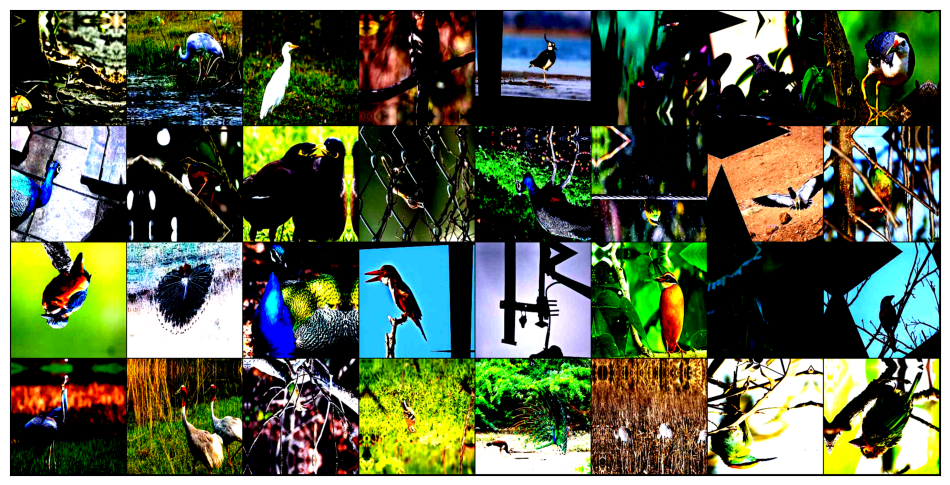

In [5]:
# Accessing labels:
print("Labels:", train_dataset.classes)

examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_loader)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classes =  ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 'White-Breasted-Waterhen', 'White-Wagtail']

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.downsample:
            x = self.downsample(x)
        identity = x
            
        out = self.relu(self.batch1(self.conv1(x)))
        out = self.batch2(self.conv2(out))
        
        out += identity
        out = self.relu(out)
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=25):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1])
        self.layer3 = self._make_layer(block, 64, layers[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=3, stride=2,padding=1),
                nn.BatchNorm2d(planes)
            )

        layers = []
        self.inplanes = planes
        layers.append(block(self.inplanes, planes,1, downsample))
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
       
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1) 
        x = self.fc(x)

        return x
    
    def eval(self,num_epochs=1,learning_rate=0.0001):
        criterion = nn.CrossEntropyLoss()
        total_step = len(train_loader)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001, momentum=0.9)
        sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs,steps_per_epoch=total_step)

        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                sched.step()
                del images, labels, outputs
                torch.cuda.empty_cache()
                gc.collect()
            
                if (i+1)%20 == 0:
                    print(f'epoch {epoch+1}/{num_epochs},step {i+1}/{total_step}, loss = {loss.item():.4f}')

    def validate(self,num_classes):
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            n_class_correct = {}
            n_class_samples = {}
            for x in classes:
                n_class_correct[x] = 0
                n_class_samples[x] = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()
                
                for i in range(num_classes):
                    label = labels[i]
                    pred = predicted[i]
                    if label == pred:
                        n_class_correct[label] += 1
                    n_class_samples[label] += 1
                del images,labels,outputs

            acc = 100.0 * n_correct / n_samples
            print(f'Accuracy of the network for val: {acc} %')

            for i in range(num_classes):
                acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                print(f'Accuracy of for val {classes[i]}: {acc} %')

In [ ]:
num_layers = 2
num_classes = 25
num_epochs = 50
learning_rate = 0.0001

model = ResNet(ResBlock, [num_layers, num_layers, num_layers]).to(device)
model.load_state_dict(torch.load('my_model.pth'))
model.eval(num_epochs,learning_rate)

In [ ]:
torch.save(model.state_dict(), 'my_model.pth')

In [ ]:
model.validate(num_classes)